# $w_0w_a$CDM Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import Bounds, minimize
from Planck18 import *
from constants import *
import emcee
import corner

%matplotlib inline

### CPL Parametrization

- $w(a) = w_0 + w_a(1-a)$ 
- $w(z) = w_0 + w_a\frac{z}{1+z}$

#### $\Omega_{DE}$
- When the equation of state $w \neq -1$, the dark energy is not represented by a constant $\Lambda$
- $\Omega_{DE} (z) = \Omega_{DE,0} \times \exp \left[ 3\int_0^z \frac{1+w(z')}{1+z'}dz'\right]$
- In terms of scale factor $a$, $\Omega_{DE} (a) = \Omega_{DE,a=1} \times \exp \left[ -3\int_0^z (1+w(a'))d\ln(a')\right]$

In [2]:
w = lambda a, w0, wa: w0 + (1-a)*wa

def eos_integrand(lna, w0, wa):
    a = np.exp(lna)
    w_now = w(a, w0, wa)
    return 1 + w_now
    
def Omega_DE(a, Omega_DE0, w0, w1):
    factor = integrate.quad(eos_integrand, 0, np.log(a), args=(w0, w1))[0]
    return Omega_DE0 * np.exp(-3 * factor)    

In [3]:
#? Distances modified to account for dark energy
a_z = lambda z: 1 / (1+z)  

def d_eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0):
    Omega_DE0 = 1 - Omega_m - Omega_rad - Omega_k
    Om_DE = Omega_DE(a, Omega_DE0, w0, wa)
    return c / 1000 / (H0*np.sqrt((Omega_m*a)+Omega_rad+(Omega_k*a**2)+Om_DE*a**4))

def eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0): 
    return integrate.quad(d_eta, a, 1, args=(Omega_m, Omega_rad, Omega_k, H0, w0, wa))[0]

def comoving_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0):
    et = eta(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=w0, wa=wa)
    if Omega_k < 0:
        return  c* np.sin(H0 * np.sqrt(-Omega_k) * et / c) / H0 / np.sqrt(-Omega_k)
    elif Omega_k > 0:
        return c * np.sinh(H0 * np.sqrt(Omega_k) * et / c, dtype=np.float128) / H0 / np.sqrt(Omega_k)
    else:
        return et

def angular_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0):
    return a * comoving_distance(a, Omega_m, Omega_rad, Omega_k, H0, w0, wa)

def luminosity_distance(a, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0):
    return angular_distance(a, Omega_m, Omega_rad, Omega_k, H0, w0, wa) / a**2

def distance_modulus(z, Omega_m=Omega_m, Omega_rad=Omega_rad, Omega_k=Omega_k, H0=H0, w0=-1, wa=0):
    a = a_z(z)
    dL = luminosity_distance(a, Omega_m, Omega_rad, Omega_k, H0, w0, wa)
    return 5 * np.log10(dL) + 25

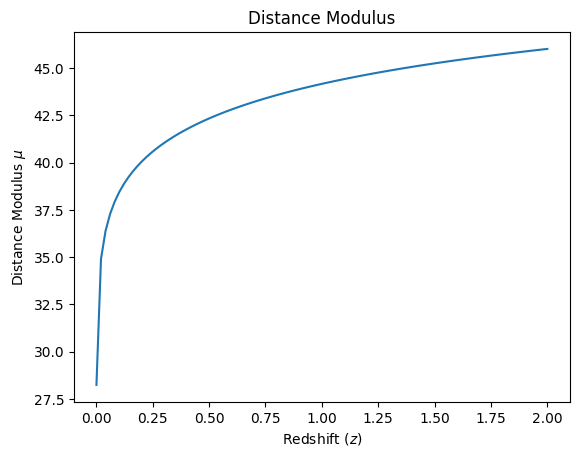

In [4]:
Z = np.linspace(1e-3, 2, 100)
DM = [distance_modulus(Z[z]) for z in range(len(Z))]
plt.plot(Z, DM)
plt.xlabel(r"Redshift ($z$)")
plt.ylabel(r"Distance Modulus $\mu$")
plt.title("Distance Modulus")
plt.show()

### Fitting $w_0$ and $w_a$ to the Union2.1 Supernovae data

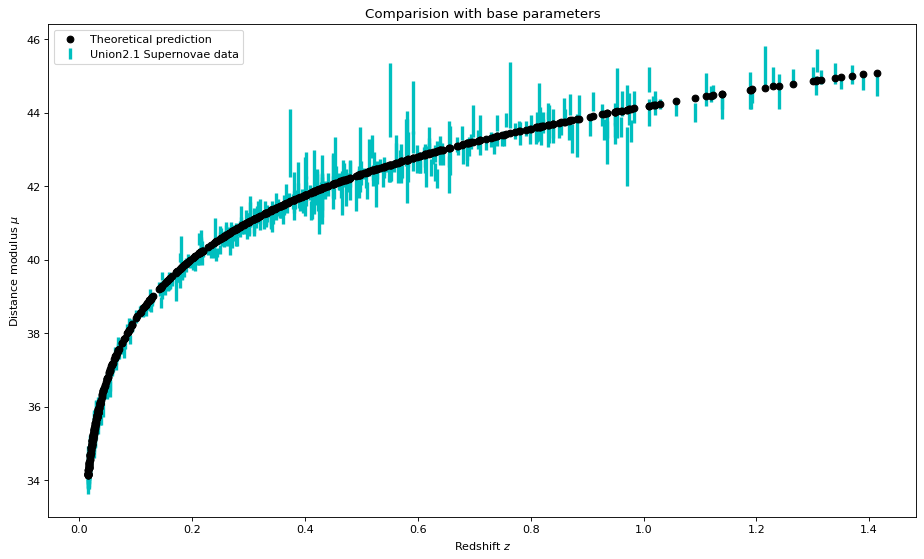

In [5]:
Z_SN, MU_SN, Delta_MU_SN = np.loadtxt("Data/sn_z_mu_dmu_plow_union2.1.txt", usecols=(1, 2, 3), unpack=True)

MU_base = np.array([distance_modulus(Z_SN[i]) for i in range(len(Z_SN))])
    
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(Z_SN, MU_base, c='k', zorder=5, linestyle="-", label='Theoretical prediction')
plt.errorbar(Z_SN, MU_SN, yerr=Delta_MU_SN, linestyle="",linewidth=3, label='Union2.1 Supernovae data', c='c', zorder=0)
plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance modulus $\mu$")
plt.title(r'Comparision with base parameters')
plt.legend()
plt.show()

In [6]:
inv_cov_mat = np.loadtxt("Data/sn_wmat_sys_union2.1.txt")

def chi_square(D, T, inv_cov_mat=inv_cov_mat):
    return (D-T).T.dot(inv_cov_mat.dot(D-T))

def chi_square_SN(params):
    Omega_m, w0, wa = params
    Omega_k = 0
    H0 = 70

    if (Omega_m > 1 or Omega_m < 0 or w0 < -3 or w0 > 1 or wa > 3 or wa < -3):
        return np.inf

    MU = np.array([distance_modulus(z, Omega_m, Omega_rad, Omega_k, H0, w0, wa) for z in Z_SN])

    return chi_square(MU, MU_SN, inv_cov_mat)

def log_chi_square_SN(params):
    return -0.5 * chi_square_SN(params)

In [7]:
Omega_m_base = 0.27
w0_base = -1
wa_base = 0

bestfit = minimize(chi_square_SN, [Omega_m_base, w0_base, wa_base], method='Nelder-Mead', bounds=Bounds([0, -3, -3], [1, 1, 3]))
print(bestfit)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 545.1104087602713
             x: [ 2.957e-01 -1.001e+00  1.632e-04]
           nit: 41
          nfev: 78
 final_simplex: (array([[ 2.957e-01, -1.001e+00,  1.632e-04],
                       [ 2.956e-01, -1.001e+00,  1.637e-04],
                       [ 2.957e-01, -1.001e+00,  1.629e-04],
                       [ 2.957e-01, -1.001e+00,  1.642e-04]]), array([ 5.451e+02,  5.451e+02,  5.451e+02,  5.451e+02]))


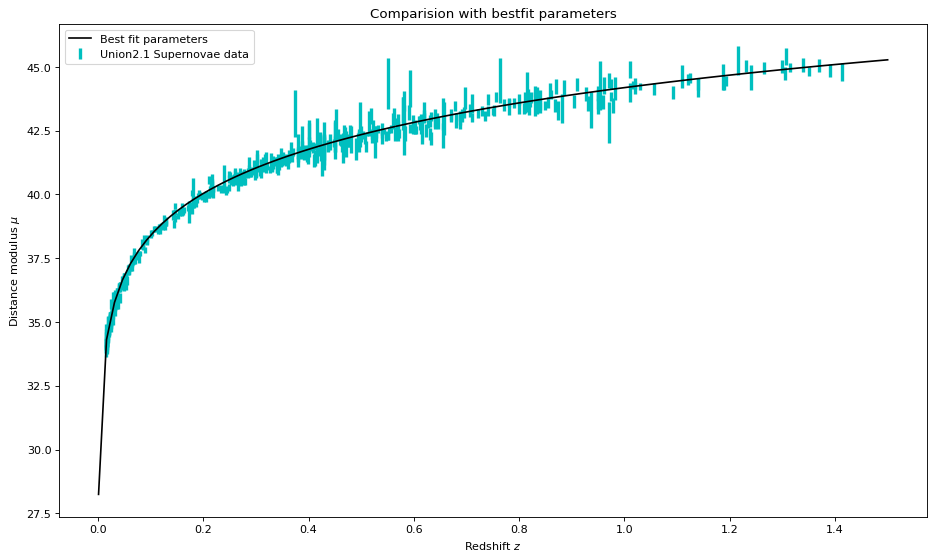

In [8]:
best_fit = bestfit.x
Omega_m_bestfit, w0_bestfit, wa_bestfit = best_fit

Z = np.linspace(1e-3, 1.5, 100)
MU = np.array([distance_modulus(z, Omega_m=Omega_m_bestfit, w0=w0_bestfit, wa=wa_bestfit) for z in Z])
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Z, MU, c='k', zorder=5, linestyle="-", label='Best fit parameters')
plt.errorbar(Z_SN, MU_SN, yerr=Delta_MU_SN, linestyle="",linewidth=3, label='Union2.1 Supernovae data', c='c', zorder=0)
plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance modulus $\mu$")
plt.title(r'Comparision with bestfit parameters')
plt.legend()
plt.show()

### Running a MCMC sample to get the likelihoods

In [11]:
ndim, nwalkers = 3, 50
iterations = 500
p0 = np.random.normal(
    best_fit,
    [0.1, 0.5, 0.5],
    size=(nwalkers, ndim)
)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_chi_square_SN)
sampler.run_mcmc(p0, iterations, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [3:01:06<00:00, 21.73s/it]


State([[ 0.45826689 -1.36776343 -1.81717749]
 [ 0.43457623 -0.86443826 -1.22612664]
 [ 0.24981362 -1.0276277   1.17658758]
 [ 0.42317193 -1.78537916 -2.41421467]
 [ 0.37035478 -1.56508531  0.89581539]
 [ 0.35458541 -1.31003463  0.92809612]
 [ 0.19383456 -1.05014119  1.60294956]
 [ 0.08411515 -0.55434455 -0.28988612]
 [ 0.35112783 -1.10679624 -1.35714171]
 [ 0.43761124 -1.48275884 -0.93467532]
 [ 0.41824581 -1.75169691  1.40153175]
 [ 0.47672644 -2.24542214 -0.36688339]
 [ 0.24517986 -0.82894912 -0.53951553]
 [ 0.12538687 -0.69745798  0.88526548]
 [ 0.27999961 -1.04255138  1.11436727]
 [ 0.18033981 -0.82228061  1.15943845]
 [ 0.41793714 -1.55340211  1.08303005]
 [ 0.19888332 -0.73199161 -0.02045487]
 [ 0.43832803 -1.72008176 -0.67115257]
 [ 0.13042821 -0.7739353   1.04984841]
 [ 0.33003697 -0.55432066 -2.46385615]
 [ 0.41768791 -1.44235179  0.26335248]
 [ 0.20470841 -1.11300091  1.75078587]
 [ 0.36407227 -0.94196639  0.48785895]
 [ 0.38657722 -1.0102834  -1.06345517]
 [ 0.44827521 -1.86

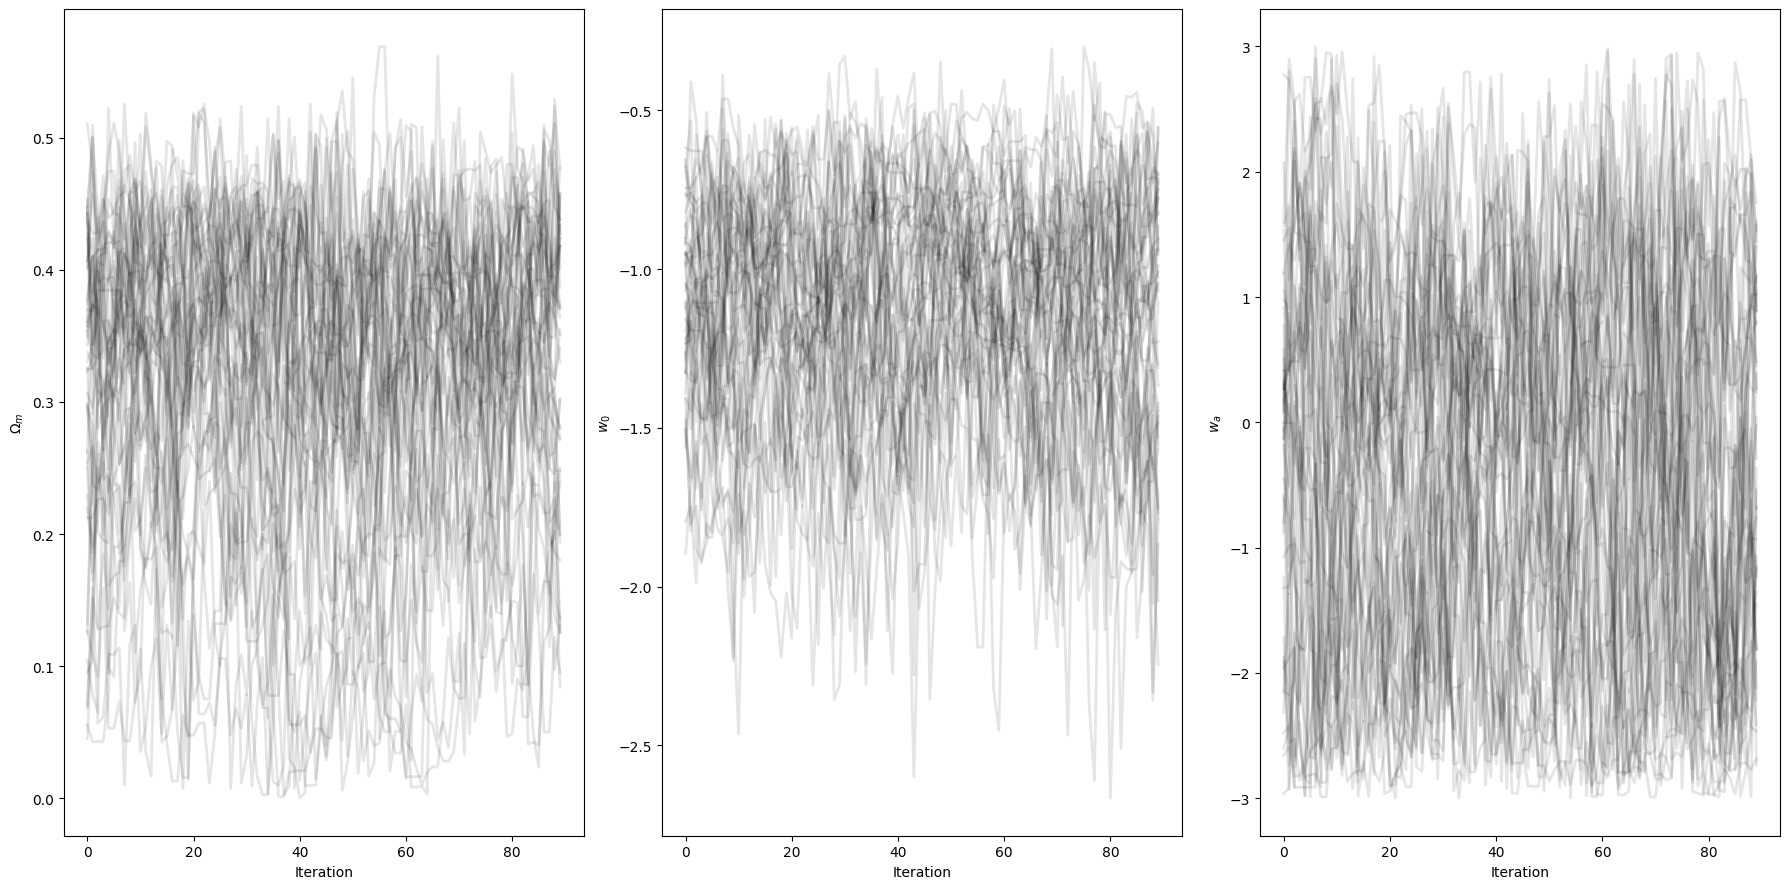

In [12]:
params = [r'$\Omega_m$', r'$w_0$',r'$w_a$']
thin, discard = 5, 50
# plot traces of parameters
plt.figure(figsize=(18, 9))
for i in range(ndim):
    plt.subplot(1, 3, i+1)
    plt.plot(sampler.get_chain(thin=thin, discard=discard)[:, :, i], color='black', alpha=0.1, lw=2)
    plt.xlabel('Iteration')
    plt.ylabel(params[i])
plt.tight_layout()

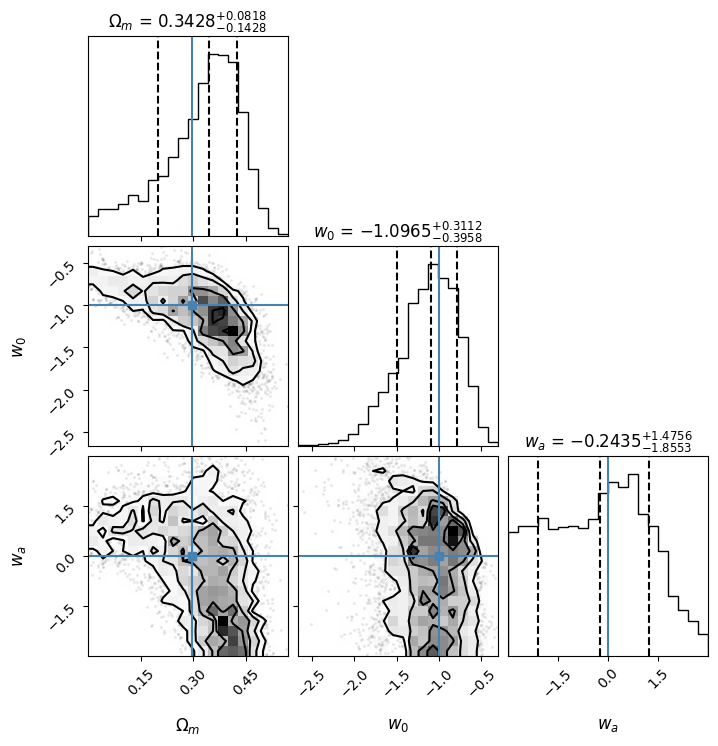

In [13]:
fig = corner.corner(sampler.get_chain(thin=thin, discard=discard, flat=True), labels=params, show_titles=True, truths=best_fit, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12}, title_fmt=".4f");
fig.savefig("MCMC Results/w0waCDM.png")